# 0. Multiprocessing improvements
- Go over current intended workflow
------------------------------------

In [1]:
import multiprocessing 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import model_based_agent as mba 
import ensemble_mod_env as eme
import utils as ut
import tab_agents as tab

from datetime import datetime 

------------
# 1. Why image processing needs to be improved
- Missing counts
- HT switching
- Multiple worms

In [2]:
dh = mba.DataHandler()
dh.load_df('ensemble_testing.pkl')

In [3]:
dh.params

{'reward_ahead': 10,
 'timestep_gap': 1,
 'prev_act_window': 3,
 'jump_limit': 100}

In [3]:
dh.df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.140,-150,-120,3,30,-30,-0.737374,"[848.3, 1068.0]"
2,1.312,30,-30,3,150,-60,-1.857143,"[848.25, 1068.0]"
3,1.500,150,-60,2,150,-60,1.714286,"[847.8333333333334, 1068.1666666666667]"
4,1.672,150,-60,1,150,150,-0.033333,"[848.0, 1068.125]"
...,...,...,...,...,...,...,...,...
43902,218.109,30,60,3,-150,60,-7.254115,"[1480.469387755102, 1080.8163265306123]"
43903,218.312,-150,60,3,-150,0,-6.373234,"[1480.7021276595744, 1080.6170212765958]"
43904,218.484,-150,0,3,-150,0,-7.764628,"[1479.842105263158, 1081.4736842105262]"
43905,218.672,-150,0,3,-120,-60,-6.646453,"[1478.9166666666667, 1082.4166666666667]"


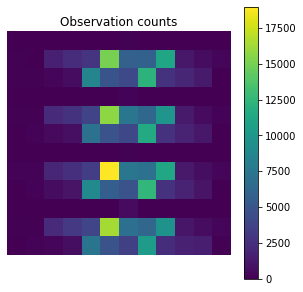

In [13]:
counts = np.zeros((12,12))
for ii,i in enumerate(np.arange(-180,180,30)):
    for jj,j in enumerate(np.arange(-180,180,30)):
        counts[ii,jj] = dh.df.query(f'obs_b=={i}&obs_h=={j}').size
plt.figure(figsize=(5,5))
plt.imshow(counts)
plt.colorbar();
plt.title('Observation counts')
plt.axis('off')
plt.ylabel('Body angle')
plt.xlabel('Head angle');

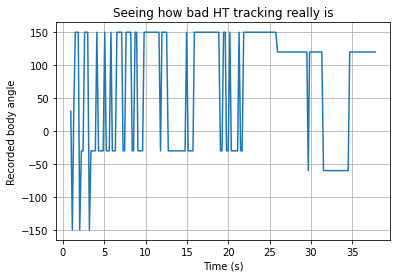

In [22]:
obs_b = dh.df['obs_b'].to_numpy()
t = dh.df['t'].to_numpy()
plt.plot(t[:200],obs_b[:200])
plt.ylabel('Recorded body angle')
plt.xlabel('Time (s)');
plt.title('Seeing how bad HT tracking really is');
plt.grid();

-------------
# 2. New smoothing method
- Current method
- Finding hyperparameters from grid search (NB ./RunMoreThings.ipynb)

--------------
# 3. Model trajectories
- Common sense checks (./RunMoreThings.ipynb)
- See how increasing amounts of data change the models, with various numbers of samples
- State histograms

In [32]:
bins = np.arange(13)
inds = np.unravel_index(obss,(12,12))
H,xedg,yedg = np.histogram2d(inds[0],inds[1], bins=(bins,bins))

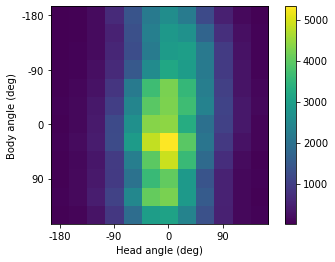

In [34]:
plt.imshow(H)
plt.colorbar();
plt.xticks(np.arange(0,12,3),np.arange(-180,180,90))
plt.yticks(np.arange(0,12,3),np.arange(-180,180,90))
plt.ylabel('Body angle (deg)')
plt.xlabel('Head angle (deg)');

----------------
# 4. Light penalty
- Current method
- Comparison to old training results (not well organized but NB ./RunThings.ipynb)

In [88]:
def eval_ep(lea,eval_steps=200000):
    obss = []
    acts = []
    rews = []
    for i in range(eval_steps):
        obs = lea.env._state
        acts.append(lea.agent.eval_act(obs))
        next_obs,rew,done,_ = lea.env.step(acts[-1])
        obss.append(next_obs)
        rews.append(rew)
    return obss,acts,rews

def plot_pol_and_qs(lea,vmin=-1,vmax=1):
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches((12,2))
    img = ax[0].imshow(np.sign(lea.agent.Qtab[:,1].reshape(12,12)-lea.agent.Qtab[:,0].reshape(12,12)))
    fig.colorbar(img,ax=ax[0]);
    ax[0].set_title('Current policy')
    img = ax[1].imshow(lea.agent.Qtab[:,1].reshape(12,12),vmin=vmin,vmax=vmax)
    fig.colorbar(img,ax=ax[1]);
    ax[1].set_title('Light on Qtable')
    img = ax[2].imshow(lea.agent.Qtab[:,0].reshape(12,12),vmin=vmin,vmax=vmax)
    plt.colorbar(img,ax=ax[2])
    ax[2].set_title('Light off Qtable')

    [ax[i].axis('off') for i in range(3)];
    
def learn_ep(lea,l_steps=1000000,ep_len=100):
    obss = []
    acts = []
    rews = []
    for i in range(l_steps):
        if i%ep_len==0:
            learners[0].env.reset()
        obs = learners[0].env._state
        acts.append(learners[0].agent.act(obs))
        next_obs,rew,done,_ = learners[0].env.step(acts[-1])
        learners[0].agent.update(obs,acts[-1],next_obs,rew)
        obss.append(next_obs)
        rews.append(rew)
    return obss,acts,rews

In [102]:
num_learners = 5
collection_eps = 1
gamma=0.25
epsilon=.5
alpha=.001
df_bound=-1
learn_limit=5000
frac=1

qtabs = []
worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) 
# Start model environments and learners 
dh = mba.DataHandler()
dh.load_df('ensemble_testing.pkl')
dh.df = dh.df[:df_bound]
      
# Make new learner list based on newest data
learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':frac},
                        gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab) 

learners[0].make_mod_and_env(dh,{'lambda':.1,'iters':10},)

On model 0


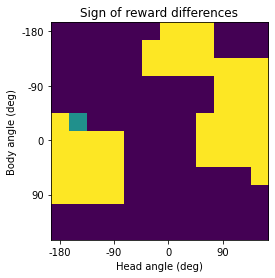

In [90]:
plt.figure(figsize=(4,4))
plt.title('Sign of reward differences')
rdiffs = np.sign(learners[0].modset.models[0]['reward_on'][:,:,0]-learners[0].modset.models[0]['reward_off'][:,:,0])
plt.imshow(rdiffs)
plt.xticks(np.arange(0,12,3),np.arange(-180,180,90))
plt.yticks(np.arange(0,12,3),np.arange(-180,180,90))
plt.ylabel('Body angle (deg)')
plt.xlabel('Head angle (deg)');

## Evaluation episode, random actions

In [44]:
obss,acts,rews = eval_ep(learners[0])

In [46]:
print(f'From init, eval episode reward is {np.mean(rews)}')

From init, eval episode reward is 0.20924083111903136


## Evaluation episode, actions based only on reward matrices

In [84]:
learners[0].agent.Qtab[:,0] = np.zeros(144)
learners[0].agent.Qtab[:,1] = np.sign(learners[0].modset.models[0]['reward_on'][:,:,0]-learners[0].modset.models[0]['reward_off'][:,:,0]).flatten()
obss,acts,rews = eval_ep(learners[0])

Just given reward matrices, no learning, eval ep is 0.4737298958928716


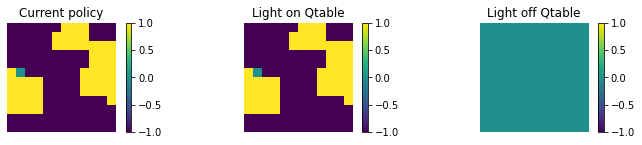

In [85]:
plot_pol_and_qs(learners[0])
print(f'Just given reward matrices, no learning, eval ep is {np.mean(rews)}')

## Learning

#### Starting point

In [103]:
obss,acts,rews = eval_ep(learners[0])

Eval ep is 0.24715848405574525


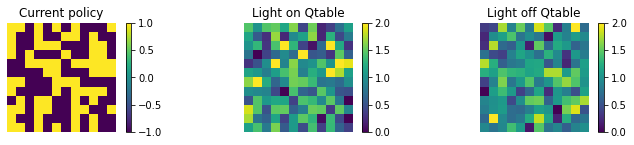

In [104]:
plot_pol_and_qs(learners[0],vmin=0,vmax=2)
print(f'Eval ep is {np.mean(rews)}')

#### After 1mil steps ( < 1.5 min for 1 mil learning + .2 mil eval steps)

In [105]:
obss,acts,rews = learn_ep(learners[0])
obss,acts,rews = eval_ep(learners[0])

1m learning steps, eval ep is 0.4563747726807795


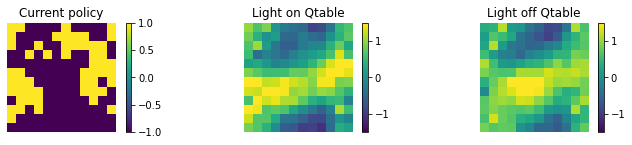

In [106]:
plot_pol_and_qs(learners[0],vmin=-1.5,vmax=1.5)
print(f'1m learning steps, eval ep is {np.mean(rews)}')

#### After 2mil steps

In [107]:
obss,acts,rews = learn_ep(learners[0])
obss,acts,rews = eval_ep(learners[0])

2m learning steps, eval ep is 0.45363238189820904


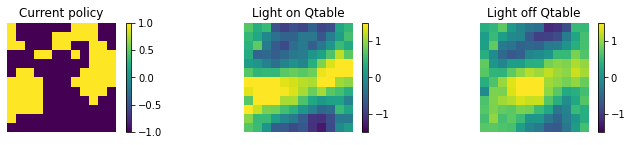

In [108]:
plot_pol_and_qs(learners[0],vmin=-1.5,vmax=1.5)
print(f'2m learning steps, eval ep is {np.mean(rews)}')

#### After 3mil steps

In [109]:
obss,acts,rews = learn_ep(learners[0])
obss,acts,rews = eval_ep(learners[0])

3m learning steps, eval ep is 0.4567496134030464


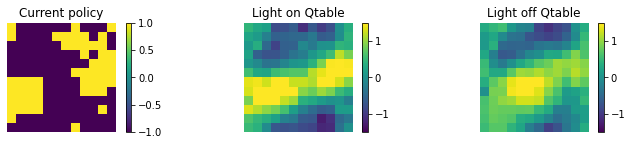

In [110]:
plot_pol_and_qs(learners[0],vmin=-1.5,vmax=1.5)
print(f'3m learning steps, eval ep is {np.mean(rews)}')

#### Immediate next step: see how gamma affects learning 

----------------
# 5. To dos:
- **Currently using optimistic starts with epsilon greedy.**
    - UCB (upper confidence bound)?
    
    
- **What about reversals? Fixes:**
    - Could do running checks instead of periodic ones (if worm has been going in opposite direction, for 5 s continuously, switch HT).
    - Could ask Sean to implement in CNN by feeding multiple frames (fast but problem could be that decisions become more black-boxy)
    
    
- **How to best use data?**
    - Multiple models vs multiple agents
    
    
- **Think about light penalty regularization**
    - What other ways are there to penalize neuron activation? https://elifesciences.org/articles/27702 Given a behavior, neuron statistics stay consistent over long timescales (several months). Could tune activation regularizer for known neuron statistics